# Sample Verasonics Analysis

In [1]:
%load_ext autoreload
%autoreload 2
import os
from pathlib import Path

print(Path().cwd())
os.chdir(Path().cwd().parent)
print(Path().cwd())

/Users/davidspector/Home/Stanford/QuantUS Projects/PyQuantUS/CLI-Demos
/Users/davidspector/Home/Stanford/QuantUS Projects/PyQuantUS


# Select Image & Phantom and Parse

In [19]:
from pyquantus.parse.verasonics import verasonicsRfParser

rfPath = Path('/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Verasonics RF/QUS_migr_1.mat')
paramPath = Path('/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Verasonics RF/param.mat')

imgData, imgInfo, refData, refInfo = verasonicsRfParser(rfPath, rfPath, paramPath)

100%|██████████| 30/30 [00:01<00:00, 20.31it/s]


In [3]:
imgData.scBmode.shape

(30, 500, 702)

# ROI Selection (synthetic example)

In [4]:
import numpy as np

xStart = 250; xEnd = 450; yStart = 100; yEnd = 300
scSplineX = np.concatenate((np.arange(xStart, xEnd, 1), [xEnd]*(yEnd-yStart), np.arange(xEnd, xStart, -1), [xStart]*(yEnd-yStart)))
scSplineY = np.concatenate(([yStart]*(xEnd-xStart), np.arange(yStart, yEnd, 1), [yEnd]*(xEnd-xStart), np.arange(yEnd, yStart, -1)))
frame = 0

# Analysis Config Example

In [8]:
from pyquantus.utc import AnalysisConfig, UltrasoundImage, UtcAnalysis

config = AnalysisConfig()

config.transducerFreqBand = [imgInfo.minFrequency, imgInfo.maxFrequency] # [min, max] (Hz)
config.analysisFreqBand = config.transducerFreqBand # [lower, upper] (Hz)
config.samplingFrequency = imgInfo.samplingFrequency # (Hz)
config.axWinSize = 1.85 # axial length per window (mm)
config.latWinSize = 1.85 # lateral length per window (mm)
config.windowThresh = 0.95 # window overlap threshold
config.axialOverlap = 0.5 # % of window overlap in axial direction
config.lateralOverlap = 0.5 # % of window overlap in lateral direction
config.centerFrequency = imgInfo.centerFrequency # Hz

# UTC Analysis

In [9]:
ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfo.yResRF # (mm/pix)
ultrasoundImage.lateralResRf = imgInfo.xResRF # (mm/pix)
ultrasoundImage.bmode = imgData.bMode[frame]
ultrasoundImage.scBmode = imgData.scBmode[frame]
ultrasoundImage.phantomRf = refData.rf[0]
ultrasoundImage.rf = imgData.rf[frame]
ultrasoundImage.xmap = imgData.scBmodeStruct.xmap
ultrasoundImage.ymap = imgData.scBmodeStruct.ymap

In [10]:
utcAnalysis = UtcAnalysis()
utcAnalysis.ultrasoundImage = ultrasoundImage
utcAnalysis.config = config
utcAnalysis.initAnalysisConfig()
utcAnalysis.scSplineX = scSplineX
utcAnalysis.scSplineY = scSplineY

In [11]:
utcAnalysis.refAttenuation = 0.5 # placeholder for attenuation coefficient at center freq (dB/cm/MHz)
utcAnalysis.refBackScatterCoef = 10e-3 # placeholder for backscatter coefficient at center freq (cm^-1 sr^-1)

In [12]:
utcAnalysis.splineToPreSc()
utcAnalysis.generateRoiWindows()
utcAnalysis.computeUtcWindows();

In [13]:
mbfArr = [window.results.mbf for window in utcAnalysis.roiWindows]
ssArr = [window.results.ss for window in utcAnalysis.roiWindows]
siArr = [window.results.si for window in utcAnalysis.roiWindows]

print("Average Midband Fit:", np.mean(mbfArr), "dB")
print("Average Spectral Slope:", np.mean(ssArr), "dB/MHz")
print("Average Spectral Intercept:", np.mean(siArr), "dB")
print("Attenuation Coefficient:", utcAnalysis.attenuationCoef, "dB/cm/MHz")
print("Backscatter Coefficient:", utcAnalysis.backScatterCoef, "1/cm-sr")
print("w Nakagami Parameter:", utcAnalysis.nakagamiParams[0])
print("u Nakagami Parameter:", utcAnalysis.nakagamiParams[1])
print("Effective Scatterer Diameter:", utcAnalysis.effectiveScattererDiameter, "µm") 
print("Effective Scatterer Concentration:", utcAnalysis.effectiveScattererConcentration, "dB/mm^3")

Average Midband Fit: 0.0 dB
Average Spectral Slope: 0.0 dB/MHz
Average Spectral Intercept: 0.0 dB
Attenuation Coefficient: 0.5 dB/cm/MHz
Backscatter Coefficient: 0.01 1/cm-sr
w Nakagami Parameter: 28451926000.0
u Nakagami Parameter: 1.0692394
Effective Scatterer Diameter: 0.2507895539511205 µm
Effective Scatterer Concentration: 17859852565.38631 dB/mm^3


# Visualizations

In [14]:
from pyquantus.utc import UtcData
from pyquantus.parse.objects import ScConfig

scConfig = ScConfig()
scConfig.width = imgInfo.width1
scConfig.tilt = imgInfo.tilt1
scConfig.startDepth = imgInfo.startDepth1
scConfig.endDepth = imgInfo.endDepth1

utcData = UtcData()
utcData.utcAnalysis = utcAnalysis
utcData.scConfig = scConfig

In [15]:
utcData.convertImagesToRGB()

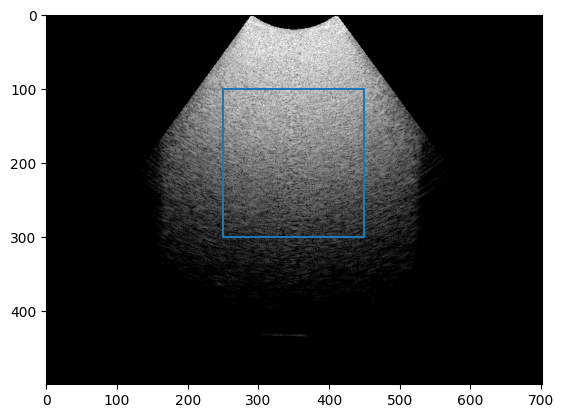

In [16]:
import matplotlib.pyplot as plt

plt.imshow(utcData.scBmode, aspect='auto')
plt.plot(scSplineX, scSplineY);

In [17]:
utcData.drawCmaps()
utcData.scanConvertCmaps()

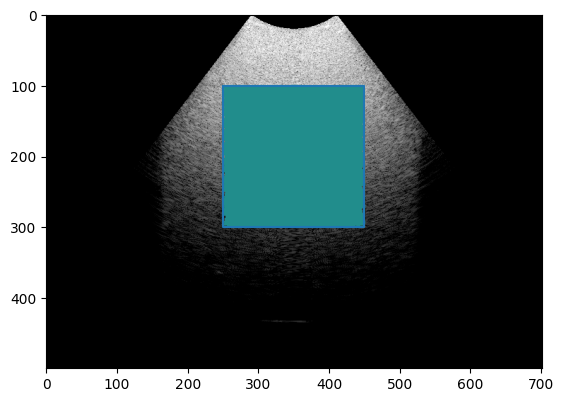

In [18]:
# Note cmap is solid as image = phantom in this case
plt.imshow(utcData.scMbfIm)
plt.plot(scSplineX, scSplineY);